In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import igraph

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.0 anndata==0.7.5 umap==0.5.1 numpy==1.20.1 scipy==1.5.3 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [3]:
results_file = 'write/210406_figure.h5ad' 

In [4]:
adata = sc.read_h5ad('write/210323.h5ad')
adata

AnnData object with n_obs × n_vars = 8058 × 18658
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_counts', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'doublet_info_colors'

In [5]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata
adata

normalizing by total count per cell
/home/analysis/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


AnnData object with n_obs × n_vars = 8058 × 18658
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_counts', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'doublet_info_colors', 'log1p'

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Highly variable genes: 2420


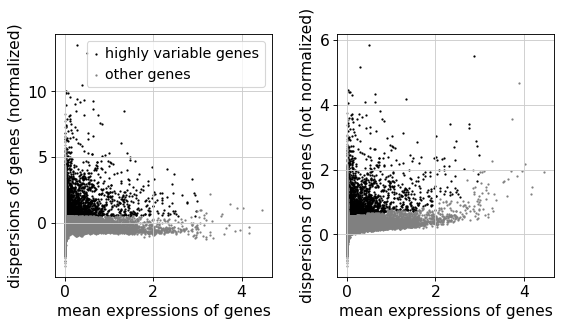

In [6]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print("Highly variable genes: %d"%sum(adata.var.highly_variable))

sc.pl.highly_variable_genes(adata)

In [8]:
adata = adata[:, adata.var['highly_variable']]

/home/analysis/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [9]:
adata

View of AnnData object with n_obs × n_vars = 8058 × 2420
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_counts', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'doublet_info_colors', 'log1p', 'hvg', 'wilcoxon'

In [10]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'])

regressing out ['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb']
    sparse input is densified and may lead to high memory use
    finished (0:00:19)


In [12]:
sc.pp.scale(adata, max_value=10)

In [13]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
/home/analysis/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    with n_comps=50
    finished (0:00:00)


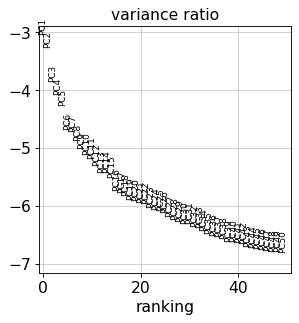

In [14]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [15]:
sc.pp.neighbors(adata, n_pcs = 40, n_neighbors = 20)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [17]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


In [18]:
sc.tl.leiden(adata, resolution = 1.0, key_added = "leiden_1.0")

running Leiden clustering
    finished: found 22 clusters and added
    'leiden_1.0', the cluster labels (adata.obs, categorical) (0:00:00)


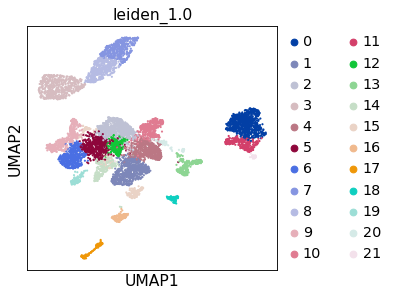

In [19]:
sc.pl.umap(adata, color='leiden_1.0')

ranking genes
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


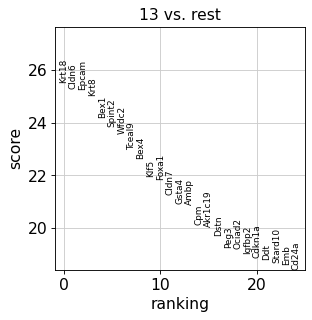

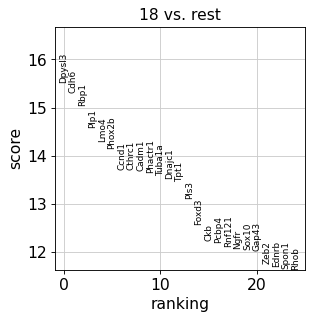

In [20]:
sc.tl.rank_genes_groups(adata, 'leiden_1.0', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, groups=['13'], n_genes=25, sharey=False, key="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=['18'], n_genes=25, sharey=False, key="wilcoxon")